In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import yfinance as yf
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.dates as mdates

In [2]:
# Function to fetch and prepare stock data
def fetch_data(stock_symbol, start_date, end_date):
    """Fetch historical stock data from Yahoo Finance."""
    data = yf.download(stock_symbol, start=start_date, end=end_date)
    # Calculate 100-day moving average
    data['MA100'] = data['Close'].rolling(window=100).mean()
    return data[['Open', 'High', 'Low', 'Close', 'MA100']]

# Function to create datasets for LSTM input and output
def create_dataset(data, time_steps=60):
    """Prepare the dataset for training the LSTM model."""
    X, y = [], []
    for i in range(len(data) - time_steps - 1):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

In [3]:
# Function to calculate and display model accuracy metrics
def calculate_accuracy_metrics(y_true, y_pred):
    """Calculate various accuracy metrics for the model predictions."""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print("\nModel Accuracy Metrics:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared (R²) Score: {r2:.4f}")
    
    return mse, rmse, mae, r2

In [4]:
# Get user input for the stock symbol
stock_symbol = input("Enter the stock symbol (e.g., AAPL): ")

# Get current date
end_date = datetime.today().strftime('%Y-%m-%d')
start_date = "2015-01-01"

# Fetch stock data for the given symbol and date range
data = fetch_data(stock_symbol, start_date, end_date)

# Scale the data using MinMaxScaler to normalize values between 0 and 1
scaler = MinMaxScaler()
# Exclude MA100 from scaling
data_to_scale = data[['Open', 'High', 'Low', 'Close',]]
data_scaled = scaler.fit_transform(data_to_scale)

[*********************100%***********************]  1 of 1 completed


In [5]:
print(data.tail())

Price             Open        High         Low       Close       MA100
Ticker          PTC.NS      PTC.NS      PTC.NS      PTC.NS            
Date                                                                  
2025-01-06  152.000000  152.500000  140.000000  141.850006  185.564708
2025-01-07  141.899994  145.639999  141.699997  144.979996  184.992791
2025-01-08  144.500000  145.119995  142.410004  143.770004  184.394171
2025-01-09  143.009995  143.339996  138.000000  138.130005  183.784601
2025-01-10  138.300003  138.699997  134.020004  134.809998  183.112821


In [6]:
# Prepare the dataset for LSTM training
time_steps = 60
X, y = create_dataset(data_scaled, time_steps)

# Split the dataset into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build and train the LSTM model (same as before)
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_steps, 4)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(4)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(
    X_train, 
    y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2
)
# Save the trained model
model.save('updated_latest_oneday.h5')  # Save model to a file
# Make predictions on test set for accuracy evaluation
test_predictions = model.predict(X_test)


# Calculate accuracy metrics
accuracy_metrics = calculate_accuracy_metrics(y_test, test_predictions)

# Predict the next day's price
last_60_days = data_scaled[-time_steps:]
predicted_next_day = model.predict(last_60_days[np.newaxis, ...])
predicted_next_day = scaler.inverse_transform(predicted_next_day)

# Prepare the predicted date
predicted_date = datetime.today() + timedelta(days=1)
predicted_date_str = predicted_date.strftime('%Y-%m-%d')



d:\_B=TECH\S8-IT NOTES\next-price\my_env\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.0046 - val_loss: 9.0945e-04
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 5.5633e-04 - val_loss: 7.1732e-04
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 4.7768e-04 - val_loss: 5.5190e-04
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 4.1375e-04 - val_loss: 5.9311e-04
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 3.8398e-04 - val_loss: 5.3346e-04
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 3.2048e-04 - val_loss: 4.7036e-04
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 2.7062e-04 - val_loss: 4.5212e-04
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 2.9228e-04 - val_loss: 5.7441e-04
Epoch 9/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 2.5723e-04 - val_loss: 4.9612e-04
Epoch 10/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 2.4184e-04 - val_loss: 3.9040e-04
Epoch 11/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 2.0891e-04 - 

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step

Model Accuracy Metrics:
Mean Squared Error (MSE): 0.0025
Root Mean Squared Error (RMSE): 0.0500
Mean Absolute Error (MAE): 0.0375
R-squared (R²) Score: 0.9508
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step



Predicted stock prices for ptc.ns on 2025-01-12:
                 Open        High         Low       Close
2025-01-12  141.27507  143.197021  138.156509  138.077362

Trend Analysis:
Current Trend: DOWNTREND
Distance from MA100: -26.38%


C:\Users\amal\AppData\Local\Temp\ipykernel_23412\2002251947.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_price = float(data['Close'].iloc[-1])
C:\Users\amal\AppData\Local\Temp\ipykernel_23412\2002251947.py:108: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  min_price = min(float(data['Close'].iloc[-30:].min()), float(predicted_next_day[0, 3])) * 0.95
C:\Users\amal\AppData\Local\Temp\ipykernel_23412\2002251947.py:109: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  max_price = max(float(data['Close'].iloc[-30:].max()), float(predicted_next_day[0, 3])) * 1.05


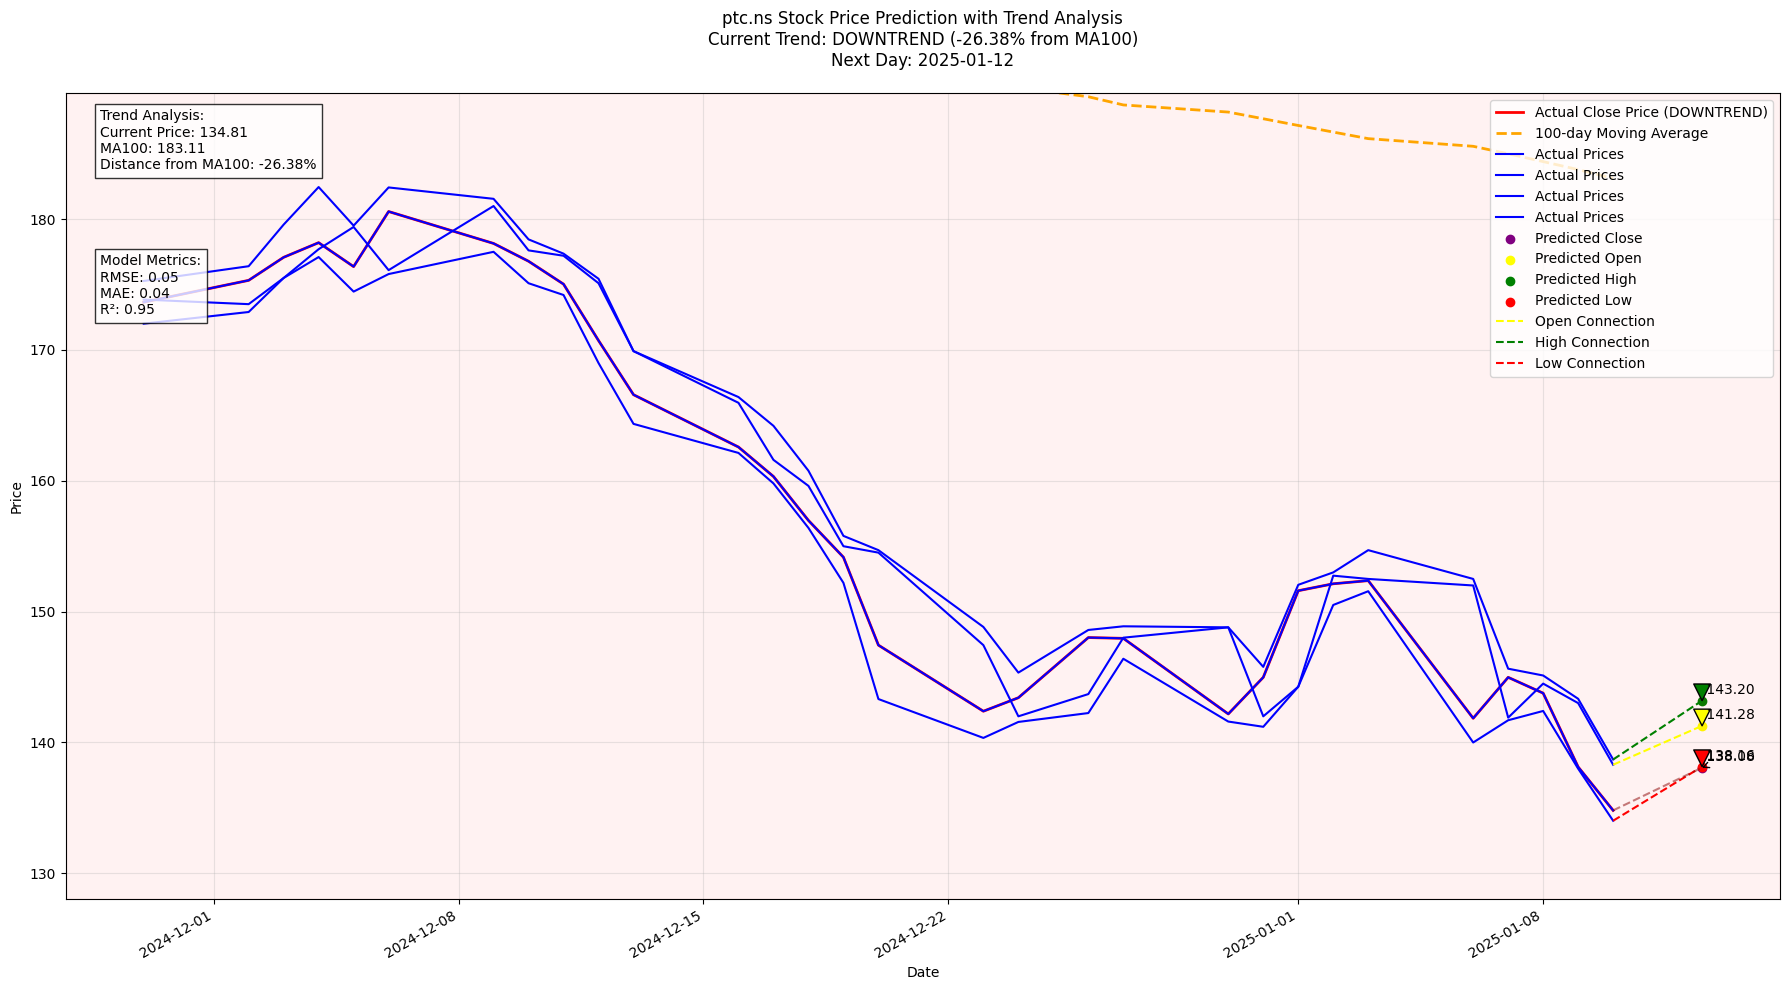

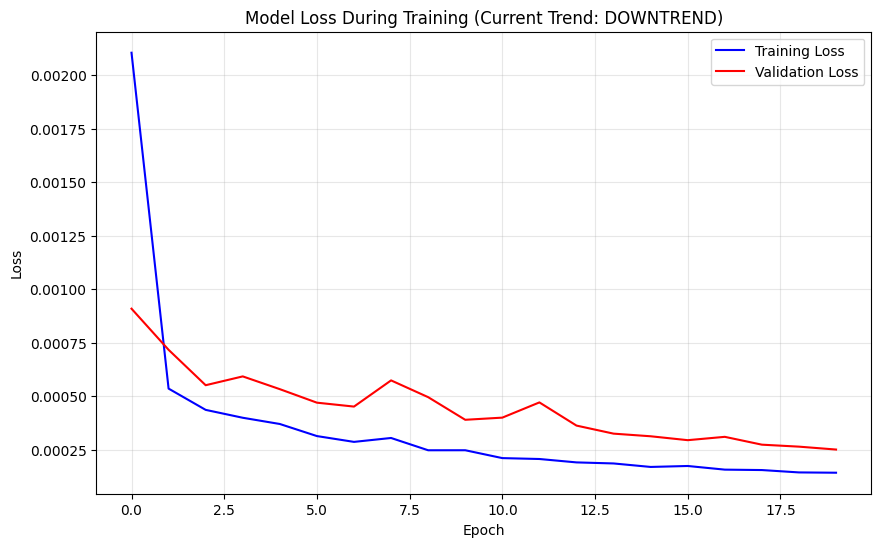

In [7]:
# Display predictions and trend analysis
predicted_df = pd.DataFrame(predicted_next_day, columns=['Open', 'High', 'Low', 'Close'], index=[predicted_date_str])
print(f"\nPredicted stock prices for {stock_symbol} on {predicted_date_str}:")
print(predicted_df)

# Analyze trend - using .item() to get scalar values
current_price = float(data['Close'].iloc[-1])
ma100_price = float(data['MA100'].iloc[-1])

trend = "UPTREND" if current_price > ma100_price else "DOWNTREND"
distance_from_ma = ((current_price - ma100_price) / ma100_price) * 100

print(f"\nTrend Analysis:")
print(f"Current Trend: {trend}")
print(f"Distance from MA100: {distance_from_ma:.2f}%")

# Create enhanced plot
plt.figure(figsize=(18, 10))

# Convert datetime index to matplotlib dates for proper plotting
last_30_dates = data.index[-30:]
plot_dates = mdates.date2num(last_30_dates)
predicted_date_num = mdates.date2num(predicted_date)

# Set colors based on trend
price_color = 'green' if trend == "UPTREND" else 'red'
prediction_color = 'darkgreen' if trend == "UPTREND" else 'darkred'

# Plot actual prices with trend-based color
plt.plot(plot_dates, data['Close'].iloc[-30:], 
         label=f'Actual Close Price ({trend})', 
         color=price_color,
         linewidth=2)

# Plot 100-day moving average
plt.plot(data.index[-30:], data['MA100'].iloc[-30:], label='100-day Moving Average', color='orange', linestyle='--', linewidth=2)

#
# Annotate Predicted Close
plt.annotate(f' {predicted_next_day[0, 3]:.2f}', 
             xy=(predicted_date, predicted_next_day[0, 3]), 
             xytext=(predicted_date, predicted_next_day[0, 3] + 0.5),
             arrowprops=dict(facecolor='purple', arrowstyle='->'), fontsize=10)

# Annotate Predicted Open
plt.annotate(f' {predicted_next_day[0, 0]:.2f}', 
             xy=(predicted_date, predicted_next_day[0, 0]), 
             xytext=(predicted_date, predicted_next_day[0, 0] + 0.5),
             arrowprops=dict(facecolor='yellow'), fontsize=10)

# Annotate Predicted High
plt.annotate(f' {predicted_next_day[0, 1]:.2f}', 
             xy=(predicted_date, predicted_next_day[0, 1]), 
             xytext=(predicted_date, predicted_next_day[0, 1] + 0.5),
             arrowprops=dict(facecolor='green'), fontsize=10)

# Annotate Predicted Low
plt.annotate(f' {predicted_next_day[0, 2]:.2f}', 
             xy=(predicted_date, predicted_next_day[0, 2]), 
             xytext=(predicted_date, predicted_next_day[0, 2] + 0.5),
             arrowprops=dict(facecolor='red'), fontsize=10)

#
# Plot predicted price
plt.plot(data.index[-30:], data[['Open', 'High', 'Low','Close']].iloc[-30:], label='Actual Prices', color='blue')
plt.scatter(predicted_date, predicted_next_day[0, 3], color='purple', label='Predicted Close')
plt.scatter(predicted_date, predicted_next_day[0, 0], color='yellow', label='Predicted Open')
plt.scatter(predicted_date, predicted_next_day[0, 1], color='green', label='Predicted High')
plt.scatter(predicted_date, predicted_next_day[0, 2], color='red', label='Predicted Low')
last_actual_point = data.iloc[-1][['Open', 'High', 'Low']].values  # Last actual prices
plt.plot(
    [data.index[-1], predicted_date],
    [last_actual_point[0], predicted_next_day[0, 0]],
    color='yellow', linestyle='--', label='Open Connection'
)
plt.plot(
    [data.index[-1], predicted_date],
    [last_actual_point[1], predicted_next_day[0, 1]],
    color='green', linestyle='--', label='High Connection'
)
plt.plot(
    [data.index[-1], predicted_date],
    [last_actual_point[2], predicted_next_day[0, 2]],
    color='red', linestyle='--', label='Low Connection'
)

# Connect last actual close price to predicted close price using numpy arrays
connection_dates = np.array([plot_dates[-1], predicted_date_num])
connection_prices = np.array([current_price, float(predicted_next_day[0, 3])])
plt.plot(connection_dates, connection_prices, 
         color=prediction_color, 
         linestyle='--',
         alpha=0.5)

# Configure x-axis to show dates properly
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()  # Rotate and align the tick labels

# Add labels and formatting
plt.title(f'{stock_symbol} Stock Price Prediction with Trend Analysis\n'
          f'Current Trend: {trend} ({distance_from_ma:.2f}% from MA100)\n'
          f'Next Day: {predicted_date_str}', 
          pad=20)
plt.xlabel('Date')
plt.ylabel('Price')

# Calculate y-axis limits properly
min_price = min(float(data['Close'].iloc[-30:].min()), float(predicted_next_day[0, 3])) * 0.95
max_price = max(float(data['Close'].iloc[-30:].max()), float(predicted_next_day[0, 3])) * 1.05

# Set y-axis limits and add shaded background
ax = plt.gca()
ax.set_ylim(min_price, max_price)
plt.axhspan(ymin=min_price, ymax=max_price,
            color=price_color, alpha=0.05)

# Customize grid
plt.grid(True, alpha=0.3)

# Add trend metrics text box
trend_metrics = (
    f'Trend Analysis:\n'
    f'Current Price: {current_price:.2f}\n'
    f'MA100: {ma100_price:.2f}\n'
    f'Distance from MA100: {distance_from_ma:.2f}%'
)
plt.text(0.02, 0.98, trend_metrics, 
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8),
         verticalalignment='top')

# Add accuracy metrics text box
metrics_text = (
    f'Model Metrics:\n'
    f'RMSE: {accuracy_metrics[1]:.2f}\n'
    f'MAE: {accuracy_metrics[2]:.2f}\n'
    f'R²: {accuracy_metrics[3]:.2f}'
)
plt.text(0.02, 0.8, metrics_text, 
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8),
         verticalalignment='top')

plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color=price_color)
plt.title(f'Model Loss During Training (Current Trend: {trend})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()